In [1]:
import warnings
from collections import OrderedDict
import pandas as pd

import scipy
import numpy as np
from scipy.integrate import solve_ivp
from sklearn.utils import resample
import pysindy as ps
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.metrics import mean_squared_error
from scipy.integrate import odeint
from scipy.stats import multivariate_normal
import seaborn as sns

In [2]:
from sklearn.linear_model import LinearRegression


class My_STLSQ:
    def __init__(self, threshold=0.05, fit_intcpt = True):
        self.threshold = threshold
        self.fit_intcpt = fit_intcpt  
                

    def fit(self, True_X, y):
        """
        Perform least squares regression with LASSO regularization
        Parameters:
        -----------
        True_X : numpy array
            Feature matrix of shape (n_samples, n_features)
        y : numpy array
            Response vector of shape (n_samples,)
        self.threshold : float
            LASSO regularization parameter

        Returns:
        --------
        coef : numpy array
            Coefficient vector of the final model
        """

        if self.fit_intcpt:
            # Add a bias term to the input data
            X_ = np.insert(True_X, 0, 1, axis=1)
        else: X_ = np.copy(True_X)

        if len(y.shape) == 1:
            y = y.reshape(-1,1)
            
        n_features = X_.shape[1]
        self.Coeffs = []
        for i in range(y.shape[-1]):
#             print(i)
            X = np.copy(X_)
            y_i = y[:,i] #.reshape(-1)
#             print(y_i.shape)
            model = LinearRegression()
            coef = np.zeros(n_features)
            while True:
                model.fit(X, y_i)
                coef_new = model.coef_
                if np.max(np.abs(coef_new - coef)) < 1e-5:
                    break
                coef = coef_new
                small_coef = np.abs(coef) < self.threshold
                if np.sum(small_coef) == 0:
                    break
                X = X[:, ~small_coef]
                coef = coef[~small_coef]
            indx = find_indexes(X_[0],X[0])
            coefficient = np.zeros(n_features)
            coefficient[indx] = coef
            self.Coeffs.append(coefficient)
        return np.array(self.Coeffs)

    def predict(self, X):
        if self.fit_intcpt:
            # Add a bias term to the input data
            X = np.insert(X, 0, 1, axis=1)
        beta = np.array(self.Coeffs)
        
        if len(beta.shape) == 1:
            beta = beta.reshape(-1,1)
            
        Y_pred = np.dot(X,beta.T)
        return np.array(Y_pred)

    
    
class SequentialThresholdLeastSquares:
    def __init__(self, threshold=0.05, fit_intcpt = True):
        self.threshold = threshold*10
        self.fit_intcpt = fit_intcpt  
                
    
    def fit(self, X, y, ):        
        if self.fit_intcpt:
            # Add a bias term to the input data
            X = np.insert(X, 0, 1, axis=1) 
        if len(y.shape) == 1:
            y = y.reshape(-1,1)
        
        self.Beta = [] #np.zeroes(y.shape[-1],X.shape[-1])
        for t in range(y.shape[-1]):
            yt = y[:,t]
            # Initialize the parameter vector
            self.beta = np.zeros(X.shape[1])

            # Compute the initial residual and RSS
            r = yt - np.dot(X, self.beta)
            RSS = np.sum(r**2)

            # Iterate until convergence
            while True:
                # Compute the correlation coefficients
                corr = np.abs(np.dot(X.T, r))

                # Find the feature with the highest correlation
                j_star = np.argmax(corr)

                # Check if the highest correlation is above the threshold
                if corr[j_star] > self.threshold:
                    # Compute the new parameter estimate for feature j_star
                    beta_j_star = np.dot(X[:,j_star], r) / np.dot(X[:,j_star], X[:,j_star])

                    # Update the parameter vector and residual
                    self.beta[j_star] += beta_j_star
                    r -= beta_j_star * X[:,j_star]
                    RSS = np.sum(r**2)
                else:
                    break
            self.Beta.append(self.beta)
        return np.array(self.Beta)
    
    def predict(self, X):
        if self.fit_intcpt:
            # Add a bias term to the input data
            X = np.insert(X, 0, 1, axis=1)
        beta = np.array(self.Beta)
        
        if len(beta.shape) == 1:
            beta = beta.reshape(-1,1)
            
        Y_pred = np.dot(X,beta.T)
        return np.array(Y_pred)

def LR(X, y, alpha, n_features):
    model = LinearRegression()
    coef = np.zeros(n_features)
    while True:
        model.fit(X, y)
        coef_new = model.coef_
        if np.max(np.abs(coef_new - coef)) < 1e-5:
            break
        coef = coef_new
        small_coef = np.abs(coef) < alpha
        if np.sum(small_coef) == 0:
            break
        X = X[:, ~small_coef]
        coef = coef[~small_coef]
    return X,coef


def find_indexes(array, elements):
    if type(array) != list:
        array = array.tolist()
        
    elements = np.array(elements)
    indexes = []
    for element in elements:
        try:
            index = array.index(element)
            indexes.append(index)
        except ValueError:
            indexes.append(None)
    return indexes

In [4]:
def plot_multivariate_normal(data, xlabel='x', ylabel='y', title='Multivariate Normal Distribution'):
    # Compute the mean and covariance of the data
    mean = np.mean(data, axis=0)
    cov = np.cov(data.T)

    # Create a grid of points for the x and y axes
    x, y = np.mgrid[mean[0]-3*np.sqrt(cov[0,0]):mean[0]+3*np.sqrt(cov[0,0]):100j,
                    mean[1]-3*np.sqrt(cov[1,1]):mean[1]+3*np.sqrt(cov[1,1]):100j]

    # Create a multivariate normal distribution using the mean and covariance
    mvn = multivariate_normal(mean=mean, cov=cov)

    # Evaluate the PDF of the multivariate normal distribution at each point on the grid
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x
    pos[:, :, 1] = y
    pdf = mvn.pdf(pos)
    
    # Set the plot title and axis labels
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Plot the multivariate normal distribution as a contour plot
    ax.contourf(x, y, pdf)
    # Show the plot
    plt.show()

def SINDY(noisy_data,t, threshold = 0.03, wl = 15, condit = False):
    """Fits SINDy model to a data and returns the resulting coefficients"""
    Poly_lib = ps.PolynomialLibrary(degree=2, include_interaction=True, include_bias=True)
    optimizer = ps.STLSQ(threshold)#threshold = 0.3)
    smoothed_fd = ps.SmoothedFiniteDifference(order=2, smoother_kws={'window_length': wl})
    dldt = smoothed_fd(noisy_data,t)
    L_dl = np.vstack((noisy_data,dldt)).T

    model = ps.SINDy(
        differentiation_method=smoothed_fd,
        feature_library=Poly_lib,
        optimizer=optimizer,
        feature_names=["L", "dL"] 
    )
    if condit: 
        model.fit(L_dl, t)
        model.print()
        model.get_feature_names()
        return model.coefficients()#.reshape(-1)
    
    else:
        model.fit(L_dl, t)
        return L_dl, model
        

def sort_matrix(matrix, col_idx = -1):
    """Sorts a matrix by a predifine column in ascending order"""
    if len(matrix.shape)  == 1:
        matrix= matrix.reshape(-1,1)
    # Sort the matrix by the specified column
    sorted_matrix = sorted(matrix, key=lambda x: x[col_idx])
    return np.array(sorted_matrix)


def split_matrix(matrix):
    """Splits the last column of a matrix from the original matrix and returns the new matrix and the column"""
    matrix = matrix.tolist()
    # Split the last column from the matrix
    last_column = [row.pop() for row in matrix]
    return np.array(matrix),np.array(last_column)

def min_idx(arr1,arr2):
    """Finds the minimum of arr2 and return the corresponding arr1 values with it """
#     arr2 = arr2.tolist()
    min_value = min(arr2)
    min_index = arr2.index(min_value)
    return ([arr1[min_index],min_value])

def differentiate(data,time, wl = 9):
    smoothed_fd = ps.SmoothedFiniteDifference(order=2, smoother_kws={'window_length': wl})
    dldt = smoothed_fd(data,time)
    d2ldt = smoothed_fd(dldt, time)
    d3ldt = smoothed_fd(d2ldt, time)
    return dldt,d2ldt,d3ldt    

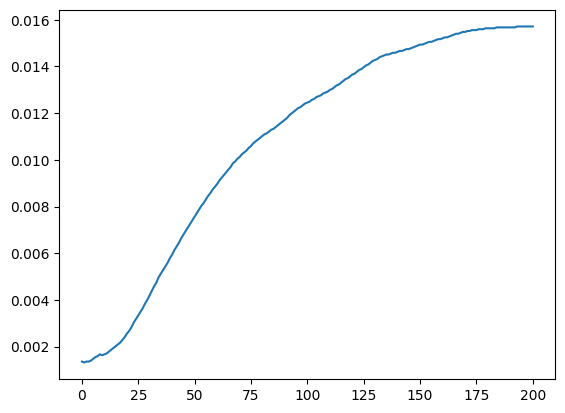

In [7]:
inf_data = pd.read_csv("Infiltration.csv")

obs_time = np.asarray(inf_data["Time (s)"])
obs_height = np.asarray(inf_data["Height (mm)"])/1000

t = np.copy(obs_time)
x = np.copy(obs_height)

a,b = x[0],x[1]
a,b = b,a
x[0],x[1] = a,b
# plt.plot(x)
# plt.plot(obs_height)

# Learning the best SINDY parameters by plotting a pareto curve

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:03<00:00,  4.28it/s]


At Threshold value = 0.4
The best window length and mse value is : [29, 0.010382735219709812]


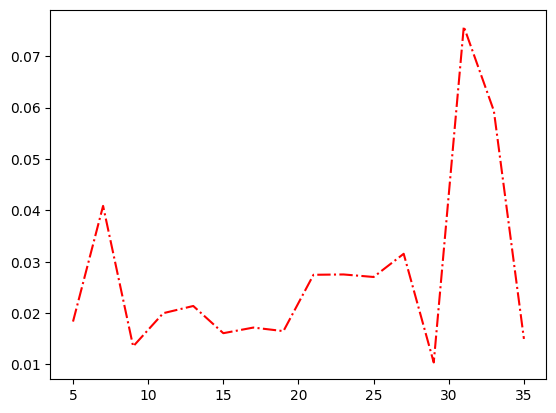

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:03<00:00,  4.46it/s]

At Threshold value = 0.5
The best window length and mse value is : [29, 0.010382735219709812]


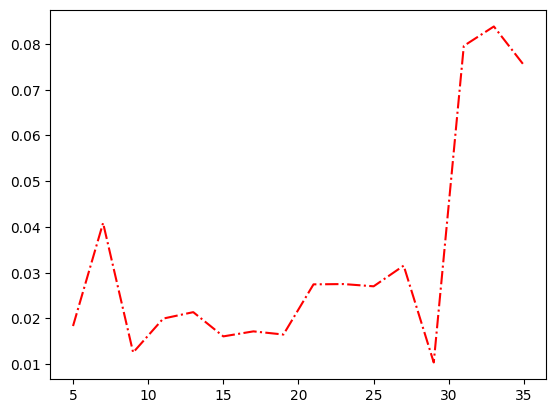

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:03<00:00,  4.77it/s]

At Threshold value = 0.6
The best window length and mse value is : [9, 0.012563158320636071]


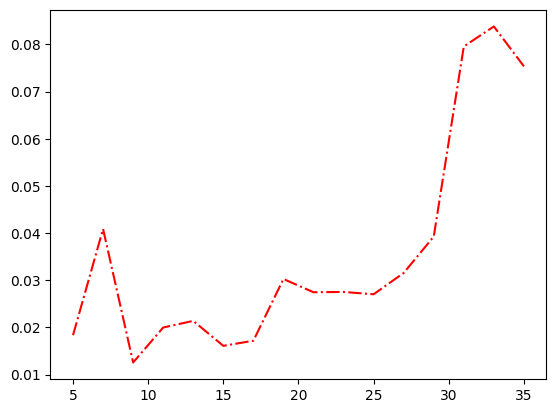

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:03<00:00,  4.71it/s]

At Threshold value = 0.7
The best window length and mse value is : [9, 0.012563158320636071]


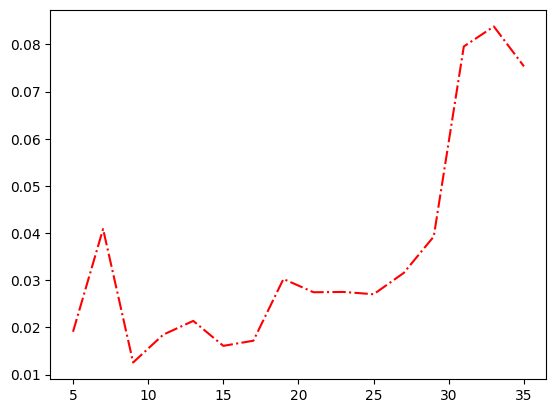

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:03<00:00,  4.22it/s]


At Threshold value = 0.8
The best window length and mse value is : [9, 0.012563158320636071]


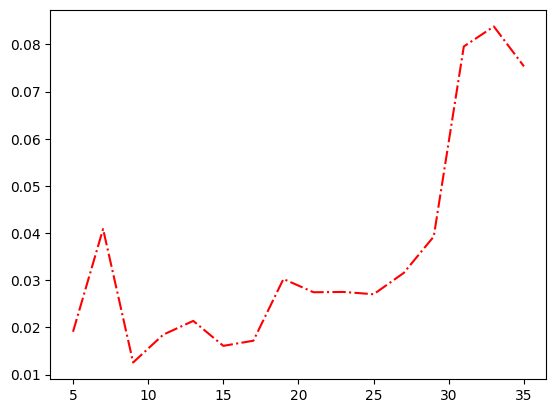

  0%|                                                                                           | 0/16 [00:00<?, ?it/s]C:\Users\USER\anaconda3\lib\site-packages\pysindy\optimizers\stlsq.py:193: UserWarning: Sparsity parameter is too big (0.8999999999999999) and eliminated all coefficients
  warnings.warn(
  6%|█████▏                                                                             | 1/16 [00:00<00:02,  5.09it/s]C:\Users\USER\anaconda3\lib\site-packages\pysindy\optimizers\stlsq.py:193: UserWarning: Sparsity parameter is too big (0.8999999999999999) and eliminated all coefficients
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\pysindy\optimizers\stlsq.py:193: UserWarning: Sparsity parameter is too big (0.8999999999999999) and eliminated all coefficients
  warnings.warn(
 12%|██████████▍                                                                        | 2/16 [00:00<00:02,  6.43it/s]C:\Users\USER\anaconda3\lib\site-packages\pysindy\optimizers\stlsq.py:193: User

At Threshold value = 0.9
The best window length and mse value is : [31, 0.0788220554773967]


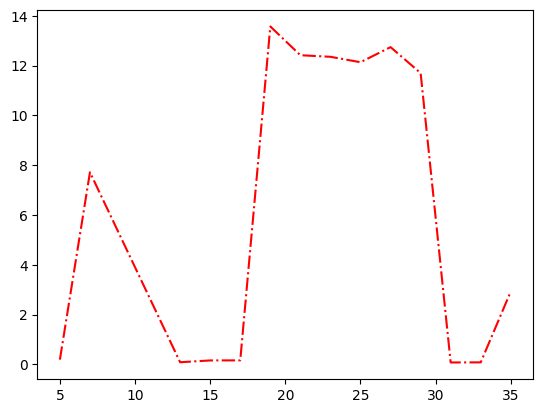

  0%|                                                                                           | 0/16 [00:00<?, ?it/s]C:\Users\USER\anaconda3\lib\site-packages\pysindy\optimizers\stlsq.py:193: UserWarning: Sparsity parameter is too big (0.9999999999999999) and eliminated all coefficients
  warnings.warn(
  6%|█████▏                                                                             | 1/16 [00:00<00:03,  3.77it/s]C:\Users\USER\anaconda3\lib\site-packages\pysindy\optimizers\stlsq.py:193: UserWarning: Sparsity parameter is too big (0.9999999999999999) and eliminated all coefficients
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\pysindy\optimizers\stlsq.py:193: UserWarning: Sparsity parameter is too big (0.9999999999999999) and eliminated all coefficients
  warnings.warn(
 12%|██████████▍                                                                        | 2/16 [00:00<00:02,  4.95it/s]C:\Users\USER\anaconda3\lib\site-packages\pysindy\optimizers\stlsq.py:193: User

At Threshold value = 1.0
The best window length and mse value is : [31, 0.0788220554773967]


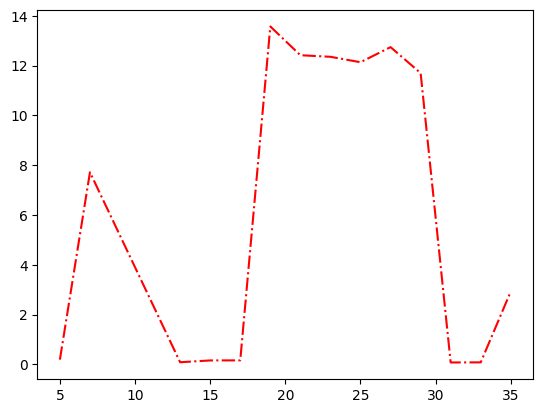

In [8]:
val_range = np.arange(0.4,1.05,0.1)
R__ =[]
indx = []
for i in range(len(val_range)):
    thresh = val_range[i]
    val_wl = np.arange(5,37,2)
    RMSE_wl =[]
    ind_tmp = []
    for i in tqdm(range(len(val_wl))):
        wl = val_wl[i]
        try:
            train, prior_mean = SINDY(x,t,thresh,wl)
            predict = prior_mean.simulate(train[0],t)
            RMSE = mean_squared_error(train[:,1],predict[:,1], squared = False)
            RMSE_wl.append(RMSE)
            ind_tmp.append(val_wl[i])
        except: # ValueError:
            continue
    mv = (min_idx(ind_tmp,RMSE_wl))
    mv.append(thresh.round(3))
    R__.append(mv)
    print(f"At Threshold value = {thresh.round(3)}")
    print(f"The best window length and mse value is : {min_idx(ind_tmp,RMSE_wl)}")
    plt.plot(ind_tmp, RMSE_wl,'r-.')
    plt.show()

### Bootstrapping the Data

In [9]:
thresh,wl = 0.4,29
smoothed_fd = ps.SmoothedFiniteDifference(order=2, smoother_kws={'window_length': wl})
dldt = smoothed_fd(x,t)
intial_vals = np.array([x[0],dldt[0]]) 
intial_vals

array([0.00131914, 0.02474585])

(L)' = 1.000 dL
(dL)' = -3.455 L + 154.509 dL + -10659.940 L dL + -578.295 dL^2
Recovered Parameter Values = 
 [-3.45534029e+00  1.54509129e+02 -1.06599397e+04 -5.78295008e+02]
RMSE = 0.010382735219709812


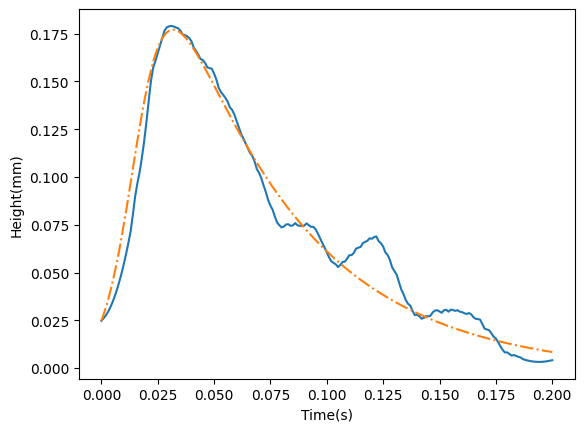

In [10]:
train, model = SINDY(x,t,thresh,wl)
model.print()
x_hat = model.simulate(train[0],t)#[:,0]
focus_idx = np.array([1,2,4,5])

plt.plot(t,train[:,1])
plt.plot(t,x_hat[:,1], '-.')

plt.xlabel('Time(s)')
plt.ylabel('Height(mm)')
plt.plot()
params = model.coefficients()[-1]
print(f"Recovered Parameter Values = \n {params[focus_idx]}")
print(f"RMSE = {mean_squared_error(train[:,1], x_hat[:,1], squared = False)}")

In [11]:
import numpy as np

def sample_and_extrapolate(array, time_array, num_samples):
    # Remove first and last row of the array and the corresponding time
    f_arr,l_arr = array[0],array[-1]
    f_time,l_time = time_array[0], time_array[-1]
    
    array_,time_array_ = np.copy(array),np.copy(time_array)
    
    array = array[1:-1]
    time_array = time_array[1:-1]
    
    # Randomly sample from the remaining array based on num_samples
    sampled_indices = sort_matrix(np.random.choice(len(array), size=num_samples, replace=False)).reshape(-1)
    sampled_array = array[sampled_indices]
    sampled_time = time_array[sampled_indices]
    
    # Add previously removed first and last row back to the array
    sampled_array = np.concatenate(([f_arr], sampled_array, [l_arr]))
    sampled_time = np.concatenate(([f_time], sampled_time, [l_time]))
    
    
    # Extrapolate for all time in the time array
    interpolated_array = np.interp(time_array_, sampled_time , sampled_array)

    return interpolated_array
x_xtrap = sample_and_extrapolate(x,t,int(0.5*len(x)))
len(x_xtrap)

201

In [12]:
# Bootstrap the data points
Lt_data = np.vstack((x,t)).T
n_bootstraps = 3000
bootstrap_params = np.zeros((n_bootstraps, len(params)))
bootstrap_set = []
Differential_set = []

for i in tqdm(range(n_bootstraps)):
    #bootstrap data
    bootstrap_data = sample_and_extrapolate(x,t,int(0.6*len(x)))
    
    #differentiate the data to get dl/dt
    diff_data = smoothed_fd(bootstrap_data,t)
    
    #append bootstrap data and their differentiation into a matrix
    bootstrap_set.append(bootstrap_data)
    Differential_set.append(diff_data)
    
    #Fit Sindy to bootstrapped data for prior paramaters
    tmp, sindy = SINDY(bootstrap_data,t,thresh,wl)
    sindy_params =  sindy.coefficients()[-1]
    
    #append the params to parameter list
    bootstrap_params[i,:] = sindy_params
    
#Convert list to array    
bootstrap_set = np.array(bootstrap_set)
Differential_set = np.array(Differential_set)

100%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:28<00:00, 106.77it/s]


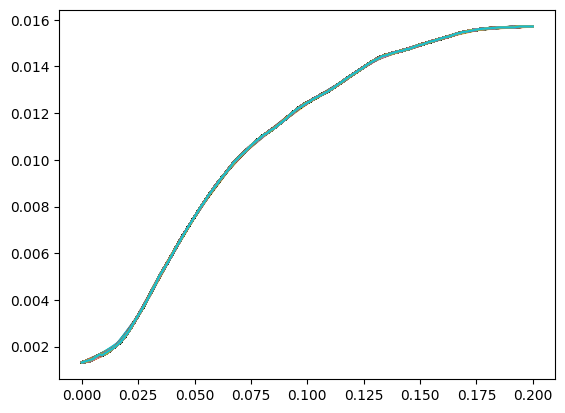

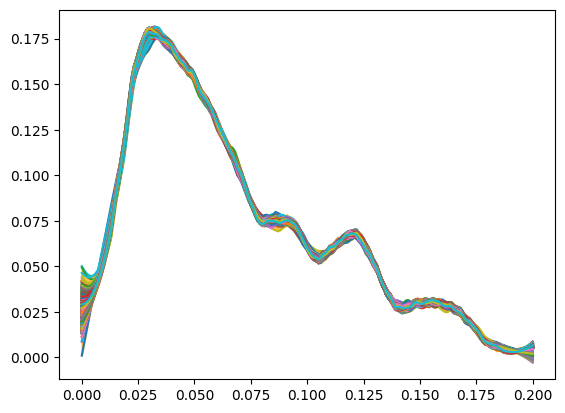

In [13]:
# Plot distribution for bootstrap data
for i in range(len(bootstrap_set)):
    plt.plot(t, bootstrap_set[i])
plt.fill_between(t, bootstrap_set.min(0), bootstrap_set.max(0), alpha=0.7, color='orange')   
plt.show()

# Plot distribution for differentiated bootstrap data
for i in range(len(Differential_set)):
    plt.plot(t, Differential_set[i])
plt.fill_between(t, Differential_set.min(0), Differential_set.max(0), alpha=0.7, color='orange')   
plt.show()

In [14]:
#Print Values from of parameters 
print("mean of the parameters = ", np.mean(bootstrap_params,0)) #mean of Sindy learned bootstraped data parameters
print("All data mean = ", params) # Recovered parameter using all data
print("mode of the parameters = ", scipy.stats.mode(bootstrap_params,axis=0).mode) #mode of bootstrap parameters

mean of the parameters =  [ 3.12118879e-03  1.73144661e+01  1.23708171e+02  1.88920573e+01
 -9.62582410e+03 -4.18106613e+02]
All data mean =  [ 0.00000000e+00 -3.45534029e+00  1.54509129e+02  0.00000000e+00
 -1.06599397e+04 -5.78295008e+02]
mode of the parameters =  [[     0.          -1470.700318        0.              0.
  -11224.70543442      0.        ]]


# Stochastic Inverse Problem Analysis